In [ ]:
import os, glob
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
!pip install kornia
import kornia
from matplotlib import pyplot as plt
import torchvision
!pip install timm
import timm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import transforms as T
from torchvision.transforms.functional import to_grayscale
from torchvision import datasets, models, transforms
from torch.nn.functional import interpolate
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

     |████████████████████████████████| 493 kB 6.9 MB/s 
     |████████████████████████████████| 431 kB 8.4 MB/s 


In [ ]:
id_dict = {}
for i, line in enumerate(open('tiny-imagenet-200/wnids.txt', 'r')):
    id_dict[line.replace('\n', '')] = i
    
class TestTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("tiny-imagenet-200/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id
        self.cls_dic = {}
        for i, line in enumerate(open('tiny-imagenet-200/val/val_annotations.txt', 'r')):
            a = line.split('\t')
            img, cls_id = a[0],a[1]
            self.cls_dic[img] = self.id_dict[cls_id]
 
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
            image = read_image(img_path,ImageReadMode.RGB)
        label = self.cls_dic[img_path.split('/')[-1]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

tinyset = TestTinyImageNetDataset(id=id_dict, transform=None)
tiny_loader = torch.utils.data.DataLoader(tinyset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
transform = T.Compose([T.Resize([224,224]),T.ToTensor(),])

placeset = datasets.Places365("../data", split='val', small=True, download=False, transform=transform)
place_loader = DataLoader(placeset, batch_size = 32, shuffle=True)

lfwset = datasets.LFWPeople("../data", split='test', image_set='original', download=False, transform=transform)
lfw_loader = DataLoader(lfwset, batch_size = 32, shuffle=True)

ncdset = datasets.ImageFolder('/content/ColorfulOriginal', transform=transform)
ncd_loader = DataLoader(ncdset, batch_size = 32, shuffle=True)

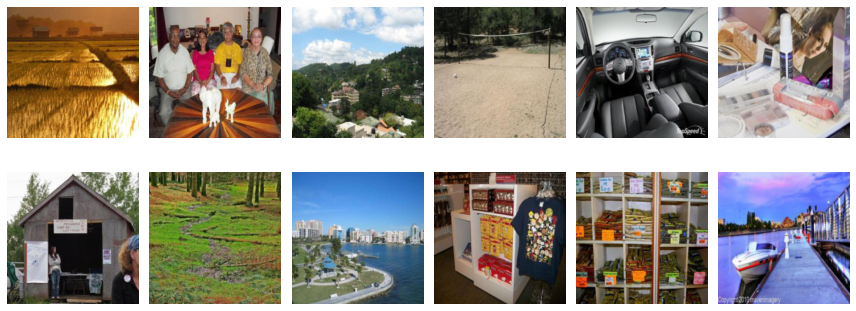

In [ ]:
#place365: 0-1
#ncd: 0-1
#lfw: 0-1
#tiny: 0-255

# def plot_images(X,M,N):
#     f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N*2,M*2.6))
#     for i in range(M):
#         for j in range(N):
#             band = X[i*N+j]
#             show_band = torch.zeros((224,224,3))                
#             show_band[:,:,0] = band[0,:,:]
#             show_band[:,:,1] = band[1,:,:]
#             show_band[:,:,2] = band[2,:,:]
#             ax[i][j].imshow(show_band.cpu().numpy())
#             ax[i][j].set_axis_off()
#     plt.tight_layout()

# for X,y in place_loader:
#     plot_images(X,2,6)
#     break

In [ ]:
# for X,y in place_loader:
#     print(X.shape)
#     for i in range(len(X)):
#         destiny1 = "input/place" + str(i) + "_1.png"
#         destiny2 = "input/place" + str(i) + "_2.png"
#         destiny3 = "input/place" + str(i) + "_3.png"
#         band = X[i]
#         save_image(band,destiny1)
#         save_image(band,destiny2)
#         save_image(band,destiny3)
#     break

# for X,y in ncd_loader:
#     print(X.shape)
#     for i in range(len(X)):
#         destiny1 = "input/ncd" + str(i) + "_1.png"
#         destiny2 = "input/ncd" + str(i) + "_2.png"
#         destiny3 = "input/ncd" + str(i) + "_3.png"
#         band = X[i]
#         save_image(band,destiny1)
#         save_image(band,destiny2)
#         save_image(band,destiny3)
#     break

# for X,y in lfw_loader:
#     print(X.shape)
#     for i in range(len(X)):
#         destiny1 = "input/lfw" + str(i) + "_1.png"
#         destiny2 = "input/lfw" + str(i) + "_2.png"
#         destiny3 = "input/lfw" + str(i) + "_3.png"
#         band = X[i]
#         save_image(band,destiny1)
#         save_image(band,destiny2)
#         save_image(band,destiny3)
#     break

# for X,y in tiny_loader:
#     print(X.shape)
#     for i in range(len(X)):
#         destiny1 = "input/tiny" + str(i) + "_1.png"
#         destiny2 = "input/tiny" + str(i) + "_2.png"
#         destiny3 = "input/tiny" + str(i) + "_3.png"
#         band = X[i]/255
#         save_image(band,destiny1)
#         save_image(band,destiny2)
#         save_image(band,destiny3)
#     break

torch.Size([32, 3, 64, 64])


In [ ]:
class dropNet(nn.Module):
    def __init__(
        self,
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        filter3_size=8,
        fc1_size=120,
        fc2_size=84,
        input_size = 224,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding = "same",
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
            padding = "same",
        )
        self.conv3 = nn.Conv2d(
            in_channels=filter2_size,
            out_channels=filter3_size,
            kernel_size=kernel_size,
            padding = "same",
        )
        self.fc1 = nn.Linear(in_features=filter3_size * int(input_size/4) ** 2, out_features=fc1_size)#nn.LazyLinear(out_features=fc1_size)#
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)
        self.dp = torch.nn.Dropout(p=0.2)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        #print(out.shape)
        out = F.relu(self.conv2(out))
        out = self.dp(out)
        #print(out.shape)
        out = F.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.dp(F.relu(self.fc1(out)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224
        
    elif model_name == "vit":
        model_ft = timm.create_model('vit_small_patch16_224',pretrained = use_pretrained)
        num_ftrs = model_ft.head.in_features
        model_ft.head = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "dropnet":
        model_ft = dropNet(num_classes = num_classes)
        input_size = 224
    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

my_model, _ = initialize_model(model_name = "vit", num_classes = 18, resume_from=None, use_pretrained=True)
my_model.load_state_dict(torch.load("/content/state_dicts/vit_imgnet"))    
my_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn

In [ ]:
def to_input(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_gray = T.Grayscale(num_output_channels=3)(img)
    mean_tensor = torch.reshape(torch.tensor(mean),(3,1,1))
    std_tensor = torch.reshape(torch.tensor(std),(3,1,1))
    return (img_gray-mean_tensor)/std_tensor

def img_stats(img):
    with torch.no_grad():
        stats = torch.zeros(len(img),18)
        img_hsv = kornia.rgb_to_hsv(img.float())
        img_yuv = kornia.rgb_to_yuv(img.float())
        for i in range(3):
            channel_rgb = img[:,i,:,:]
            channel_hsv = img_hsv[:,i,:,:]
            channel_yuv = img_yuv[:,i,:,:]
            stats[:,2*i] = torch.mean(channel_rgb,(1,2))
            stats[:,2*i+1] = torch.std(channel_rgb,(1,2))
            stats[:,6+2*i] = torch.mean(channel_hsv,(1,2))
            stats[:,6+2*i+1] = torch.std(channel_hsv,(1,2))
            stats[:,12+2*i] = torch.mean(channel_yuv,(1,2))
            stats[:,12+2*i+1] = torch.std(channel_yuv,(1,2))
        return stats
    
def get_loss(model, loader):
    i = 0
    loss_module = nn.MSELoss()
    with torch.no_grad():
        total_loss = 0        
        for X, y in loader:
            i+=1
            if (i%100==0):
                print(i)
            yp = model(to_input(X))
            yt = img_stats(X)
            loss = loss_module(yp, yt)
            total_loss += loss.item()
        print("loss is ", total_loss)            
        return total_loss
    
def tiny_imgnet_loss(model):
    i = 0
    loss_module = nn.MSELoss()
    with torch.no_grad():
        total_loss = 0        
        for X, y in tiny_loader:
            i+=1
            if (i%100==0):
                print(i)    
            yp = model(to_input(interpolate(X/255,(224,224))))
            yt = img_stats(X/255)
            loss = loss_module(yp, yt)
            total_loss += loss.item()
        print("loss is ", total_loss)            
        return total_loss
    
#training set loss start from 120-130, after 20 epoch
#dropnet: 41.183523337356746
#alexnet: 18.92139094416052
#resnet50: 10.813235650304705
#vit: 5.674639716395177

#place365-val: 36500 images (1141 batch), ncd: 723 images (23 batch), lfw: 3708 images (116 batch)
#tiny imagenet: 10000 images (313 batch)

#resnet50 loss: 72.08442063070834, 1.789659321308136, 6.041690234094858, 27.571896716952324
#resnet50 average: 0.0632, 0.0778, 0.0521, 0.0881

#vit loss: 79.36780595220625, 1.837092000991106, 6.925427544862032, 30.309515830129385
#vit average: 0.06956, 0.0799, 0.0597, 0.0968

#alexnet loss: 80.19657791405916, 1.5387395396828651, 7.372547529637814, 29.288418743759394
#alexnet average: 0.0703, 0.0669, 0.0636, 0.0936

#dropnet loss: 88.17126314714551, 1.974208153784275, 7.28841932117939, 29.723836045712233
#dropnet average: 0.0773, 0.0858, 0.0628, 0.0950

# for loader in [place_loader,ncd_loader,lfw_loader]:
#     get_loss(my_model,loader)
#tiny_imgnet_loss(my_model)


In [ ]:
tiny_mean, tiny_std = [122.4786, 114.2755, 101.3963], [70.4924, 68.5679, 71.8127]

def to_input(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_gray = T.Grayscale(num_output_channels=3)(img)
    mean_tensor = torch.reshape(torch.tensor(mean),(3,1,1))
    std_tensor = torch.reshape(torch.tensor(std),(3,1,1))
    return (img_gray-mean_tensor)/std_tensor

def img_to_input(ds_name,indx,num = 0,ext=".png"):
    xi_bgr = []
    #for i in range(1):
    if num >0:
        destiny = "output/" + ds_name + str(indx) + "_"+str(num)+ext
    else:
        if (ds_name in ['tiny','place','ign']):
          destiny = "input/" + ds_name + str(indx) + ext
        else:
          destiny = "input/" + ds_name + str(indx) + "_1" + ext
    print(destiny)
    np_bgr = cv2.imread(destiny)
    x_bgr = torch.tensor(kornia.image_to_tensor(np_bgr,keepdim=False),dtype=torch.float32)
    xi_bgr.append(x_bgr/255)
    xb_bgr = torch.cat(xi_bgr)
    xb_rgb = kornia.color.bgr_to_rgb(xb_bgr)
    xb_gray = to_input(xb_rgb)
    if (ds_name=="tiny"):
        xb_gray = interpolate(xb_gray,(224,224))
    return xb_gray.cuda()

def img_to_rgb(ds_name,indx,num = 0,ext=".png"):
    xi_bgr = []
    if num >0:
        destiny = "output/" + ds_name + str(indx) + "_"+str(num)+ext
    else:
        if (ds_name in ['tiny','place','ign']):
          destiny = "input/" + ds_name + str(indx) + ext
        else:
          destiny = "input/" + ds_name + str(indx) + "_1" + ext
    np_bgr = cv2.imread(destiny)
    x_bgr = torch.tensor(kornia.image_to_tensor(np_bgr,keepdim=False),dtype=torch.float32)
    xi_bgr.append(x_bgr/255)
    xb_bgr = torch.cat(xi_bgr)
    xb_rgb = kornia.color.bgr_to_rgb(xb_bgr)
    return xb_rgb.cuda()

def img_stats(img):
    with torch.no_grad():
        stats = torch.zeros(len(img),18)
        img_hsv = kornia.rgb_to_hsv(img.float())
        img_yuv = kornia.rgb_to_yuv(img.float())
        for i in range(3):
            channel_rgb = img[:,i,:,:]
            channel_hsv = img_hsv[:,i,:,:]
            channel_yuv = img_yuv[:,i,:,:]
            stats[:,2*i] = torch.mean(channel_rgb,(1,2))
            stats[:,2*i+1] = torch.std(channel_rgb,(1,2))
            stats[:,6+2*i] = torch.mean(channel_hsv,(1,2))
            stats[:,6+2*i+1] = torch.std(channel_hsv,(1,2))
            stats[:,12+2*i] = torch.mean(channel_yuv,(1,2))
            stats[:,12+2*i+1] = torch.std(channel_yuv,(1,2))
        return stats
    
# X = img_to_input("place")
# yp = my_model(X)
# Xt = img_to_rgb("place")
# yt = img_stats(Xt)

# for ds in ["place","ncd","lfw","tiny"]:
#     X = img_to_input(ds)
#     yp = my_model(X)
#     print(yp)

In [ ]:
from torch.nn.modules import loss
best = {}
loss = {}
extension={"ign" : ".jpeg","place":".png","tiny":".png", "lfw":".png", "ncd":".png"}
for ds in ["ncd"]:#, "ncd"
    ext = extension[ds]
    for indx in range(32):
        # to get model predicted statistics:
        X = img_to_input(ds,indx, num=0, ext=ext)
        yp = my_model(X)
        # to get ground truth statistics:
        #X = img_to_rgb(ds,indx,num=0, ext=ext)
        #yp = img_stats(X)
        Xt1 = img_to_rgb(ds,indx,num=1,ext=ext)
        yt1 = img_stats(Xt1)
        Xt2 = img_to_rgb(ds,indx,num=2,ext=ext)
        yt2 = img_stats(Xt2)
        Xt3 = img_to_rgb(ds,indx,num=3,ext=ext)
        yt3 = img_stats(Xt3)
        loss1 = nn.MSELoss()(yp,yt1).detach().numpy()
        loss2 = nn.MSELoss()(yp,yt2).detach().numpy()
        loss3 = nn.MSELoss()(yp,yt3).detach().numpy()
        loss[ds+str(indx)] = (loss1,loss2,loss3)
        if loss1 <= loss2 and loss1 <= loss3:
            best[ds+str(indx)] = 1
        elif loss2<= loss1 and loss2<= loss3:
            best[ds+str(indx)] = 2
        elif loss3<= loss1 and loss3<= loss2:
            best[ds+str(indx)] = 3
    print(best)
    print(loss)
#nn.MSELoss()()
# Save
#np.save('compare/gt_best.npy', best) 
#np.save('compare/gt_loss.npy', loss)

In [ ]:
def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)
full_result = []
model = "vit/"
#from cv2 import cv2_imshow
for ds in ["ncd"]:#,"place","tiny", "lfw", "ncd"
    ext = extension[ds]
    for indx in range(32):
        if ds+str(indx) in best.keys():
            img0= cv2.imread("input/" + ds + str(indx) +"_1"+ext) 
            # cv2_imshow(img0)#'Ground Truth',
            # for j in range(1,4):
            # print("input/" + ds + str(indx) +"_"+str(j)+".jpeg")
            img1 = cv2.imread("output/" + ds + str(indx) +"_1"+ext) 
            # cv2_imshow(img1)#'Colorization '+str(j),
            img2 = cv2.imread("output/" + ds + str(indx) +"_2"+ext) 
            # cv2_imshow(img2)#'Colorization '+str(j),
            img3 = cv2.imread("output/" + ds + str(indx) +"_3"+ext) 
            # cv2_imshow(img3)#'Colorization '+str(j),
            imgb = cv2.imread("output/" + ds + str(indx) +"_"+str(best[ds+str(indx)])+ext) 
            # cv2_imshow(imgb)#'Best Colorization is '+str(best[ds+str(indx)]),
            result = hconcat_resize_min([img0,img1,img2,img3,imgb])
            full_result.append(result)
            #cv2.imshow(result)
            cv2.imwrite('/content/compare/'+model+ds + str(indx) +"_result"+ext, result)

In [ ]:
# Load
resnet50_best = np.load('best_and_loss/resnet50_best.npy',allow_pickle='TRUE').item()
dropnet_best = np.load('best_and_loss/dropnet_best.npy',allow_pickle='TRUE').item()
alexnet_best = np.load('best_and_loss/alexnet_best.npy',allow_pickle='TRUE').item()
vit_best = np.load('best_and_loss/vit_best.npy',allow_pickle='TRUE').item()
gt_best = np.load('best_and_loss/gt_best.npy',allow_pickle='TRUE').item()
human_best = {'lfw0': 3, 'lfw1': 1, 'lfw2': 1, 'lfw3': 3, 'lfw4': 1, 'lfw5': 1, 'lfw6': 2, 'lfw7': 2, 'lfw8': 1, 'lfw9': 2, 'lfw10': 1, 
              'lfw11': 2, 'lfw12': 1, 'lfw13': 2, 'lfw14': 1, 'lfw15': 1, 'lfw16': 2, 'lfw17': 1, 'lfw18': 2, 'lfw19': 1, 'lfw20': 1, 
              'lfw21': 2, 'lfw22': 2, 'lfw23': 3, 'lfw24': 1, 'lfw25': 2, 'lfw26': 2, 'lfw27': 2, 'lfw28': 2, 'lfw29': 1, 'lfw30': 3, 'lfw31': 1, 
              'ncd0': 1, 'ncd1': 1, 'ncd2': 3, 'ncd3': 1, 'ncd4': 1, 'ncd5': 1, 'ncd6': 3, 'ncd7': 3, 'ncd8': 2, 'ncd9': 2, 'ncd10': 2, 
              'ncd11': 3, 'ncd12': 2, 'ncd13': 3, 'ncd14': 1, 'ncd15': 2, 'ncd16': 3, 'ncd17': 1, 'ncd18': 2, 'ncd19': 3, 'ncd20': 3, 
              'ncd21': 1, 'ncd22': 1, 'ncd23': 2, 'ncd24': 2, 'ncd25': 2, 'ncd26': 3, 'ncd27': 2, 'ncd28': 2, 'ncd29': 3, 'ncd30': 3, 'ncd31': 3, 
              'ign0': 2, 'ign1': 1, 'ign2': 1, 'ign3': 2, 'ign4': 3, 'ign5': 1, 'ign6': 1, 'ign7': 2, 'ign8': 1, 'ign9': 3, 'ign10': 1, 
              'ign11': 3, 'ign12': 1, 'ign13': 3, 'ign14': 1, 'ign15': 2, 'ign16': 1, 'ign17': 3, 'ign18': 3, 'ign19': 3, 'ign20': 2, 
              'ign21': 3, 'ign22': 2, 'ign23': 2, 'ign24': 3, 'ign25': 1, 'ign26': 3, 'ign27': 3, 'ign28': 2, 'ign29': 1, 'ign30': 1, 'ign31': 2, 
              'place0': 3, 'place1': 1, 'place2': 1, 'place3': 2, 'place4': 2, 'place5': 2, 'place6': 1, 'place7': 2, 'place8': 3, 'place9': 3, 'place10': 3, 
              'place11': 3, 'place12': 3, 'place13': 2, 'place14': 3, 'place15': 2, 'place16': 1, 'place17': 3, 'place18': 1, 'place19': 2, 'place20': 2, 
              'place21': 3, 'place22': 3, 'place23': 1, 'place24': 3, 'place25': 1, 'place26': 2, 'place27': 2, 'place28': 2, 'place29': 3, 'place30': 3, 'place31': 1, 
              'tiny0': 3, 'tiny1': 3, 'tiny2': 2, 'tiny3': 3, 'tiny4': 3, 'tiny5': 1, 'tiny6': 2, 'tiny7': 1, 'tiny8': 3, 'tiny9': 3, 'tiny10': 2, 
              'tiny11': 1, 'tiny12': 2, 'tiny13': 3, 'tiny14': 3, 'tiny15': 3, 'tiny16': 3, 'tiny17': 3, 'tiny18': 3, 'tiny19': 3, 'tiny20': 3, 
              'tiny21': 2, 'tiny22': 3, 'tiny23': 3, 'tiny24': 1, 'tiny25': 3, 'tiny26': 3, 'tiny27': 2, 'tiny28': 3, 'tiny29': 3, 'tiny30': 2, 'tiny31': 1}

def get_matches(best1,best2):
    dss = ["ncd","lfw","place","tiny","ign"]
    match = {'lfw':0,'ncd':0,'place':0,'tiny':0,'ign':0}
    for k in best1:
        for ds in dss:
            if k.startswith(ds):
                match[ds] += (best1[k]==best2[k])
                break
    return match

print(get_matches(gt_best,human_best))
for best in [dropnet_best,vit_best,alexnet_best,resnet50_best]:
    print(gt_best["ign0"],best["ign0"])
    print("\n")
    print(get_matches(gt_best,best))
    print(get_matches(best,human_best))

{'lfw': 25, 'ncd': 20, 'place': 21, 'tiny': 13, 'ign': 19}
2 1


{'lfw': 17, 'ncd': 17, 'place': 11, 'tiny': 12, 'ign': 16}
{'lfw': 16, 'ncd': 14, 'place': 15, 'tiny': 9, 'ign': 8}
2 3


{'lfw': 15, 'ncd': 15, 'place': 15, 'tiny': 12, 'ign': 14}
{'lfw': 18, 'ncd': 13, 'place': 13, 'tiny': 13, 'ign': 11}
2 3


{'lfw': 18, 'ncd': 19, 'place': 10, 'tiny': 11, 'ign': 12}
{'lfw': 20, 'ncd': 13, 'place': 13, 'tiny': 11, 'ign': 10}
2 3


{'lfw': 18, 'ncd': 13, 'place': 16, 'tiny': 14, 'ign': 13}
{'lfw': 20, 'ncd': 16, 'place': 20, 'tiny': 12, 'ign': 13}
